In [44]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [46]:
def find_non_offsets(string, offsets):
    offsets.sort(key=lambda x: x[0])
    
    merged_offsets = []
    for start, end in offsets:
        if not merged_offsets or merged_offsets[-1][1] < start - 1:
            merged_offsets.append((start, end))
        else:
            merged_offsets[-1] = (merged_offsets[-1][0], max(merged_offsets[-1][1], end))
    
    non_offsets = []
    last_end = -1  
    for start, end in merged_offsets:
        if last_end + 1 < start:
            non_offsets.append((last_end + 1, start - 1))
        last_end = end
    
    if last_end + 1 < len(string):
        non_offsets.append((last_end + 1, len(string) - 1))
    
    return non_offsets



In [65]:

def process_data(data: pd.DataFrame):
    
    post_id = []
    subreddit_id = []
    input_string = []
    output_string_with_offset_list = []
    output_string_with_sentence_list = []
    data_distribution = {'per_exp': 0, 'claim_per_exp': 0, 'question': 0, 'claim' : 0, 'none' : 0 }
    
    data['cleaned_text'] = data['text'].str.replace('&#x200B;', '', regex=False)
    
    for  index, row in data.iterrows():
        offset_list = []
        x = ast.literal_eval(row['stage1_labels'])
        dict_label = {'per_exp': [], 'claim_per_exp': [], 'question': [], 'claim' : [], 'none': []}
        dict_label_sentence = {'per_exp': [], 'claim_per_exp': [], 'question': [], 'claim' : [], 'none': []}
        # print(row['text'])
        for label in x[0]['crowd-entity-annotation']['entities']:
            s, e = label['startOffset'], label['endOffset']
            if s!=0:
                s = s -  1
            offset_list.append((s, e))
            if label['label'] == 'per_exp':
                dict_label['per_exp'].append((s, e))
                dict_label_sentence['per_exp'].append(row['cleaned_text'][s: e])
                data_distribution['per_exp'] = data_distribution['per_exp'] + 1
            elif label['label'] == 'claim_per_exp':
                dict_label['claim_per_exp'].append((s, e))
                dict_label_sentence['claim_per_exp'].append(row['cleaned_text'][s: e])
                data_distribution['claim_per_exp'] = data_distribution['claim_per_exp'] + 1
            elif label['label'] == 'question':
                dict_label['question'].append((s, e))
                dict_label_sentence['question'].append(row['cleaned_text'][s: e])
                data_distribution['question'] = data_distribution['question'] + 1
            else:
                dict_label['claim'].append((s, e))
                dict_label_sentence['claim'].append(row['cleaned_text'][s: e])
                data_distribution['claim'] = data_distribution['claim'] + 1
        
        none_offset = find_non_offsets(row['cleaned_text'], offset_list)
        dict_label['none'].extend(none_offset)
        for non_off in none_offset:
            dict_label_sentence['none'].append(row['cleaned_text'][non_off[0]: non_off[1]])
        data_distribution['none'] = data_distribution['none'] + len(none_offset)
        
            
        post_id.append(row['post_id'])
        subreddit_id.append(row['subreddit_id'])
        input_string.append(row['cleaned_text'])
        output_string_with_offset_list.append(str(dict_label))
        output_string_with_sentence_list.append(str(dict_label_sentence))
        
    df = pd.DataFrame({'post_id': post_id, 'subreddit_id': subreddit_id, 'text': input_string, 'output_with_offset': output_string_with_offset_list\
                       , 'output_with_sentence': output_string_with_sentence_list})
    data_distribution_sorted = dict(sorted(data_distribution.items(), key=lambda item: item[1]))
    return df,  data_distribution_sorted




In [70]:
df  = pd.read_csv('st1_train_inc_text.csv')
df_processed,  data_distribution = process_data(df)
df_processed.to_csv('ST1_data_processed_train.csv', index=False)

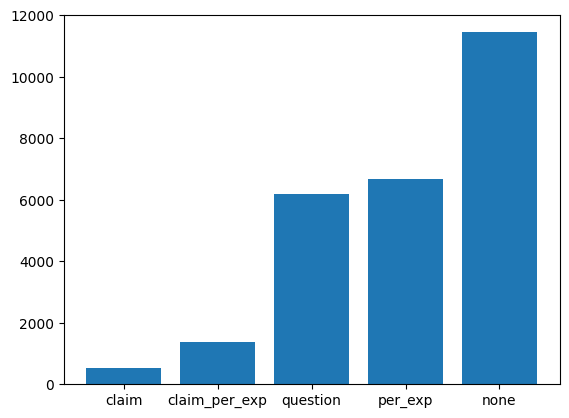

In [71]:
plt.bar(*zip(*data_distribution.items()))
plt.show()

In [73]:
df_test  = pd.read_csv('st1_test_inc_text.csv')
df_test['cleaned_text'] = df_test['text'].str.replace('&#x200B;', '', regex=False)
df_test.to_csv('ST1_data_processed_test.csv')
